In [1]:
import utils.model
import pandas as pd
import utils.constants
import sklearn
import numpy as np

In [2]:
train_data = pd.read_parquet("preprocessed_training_features\\part.0.parquet")
test_data = pd.read_parquet("preprocessed_validation_features\\part.1.parquet")
feature_columns_w_TE = ['a_is_verified', 'b_is_verified',
       'a_follows_b', 'bert_token_len',
        'n_photos', 'n_videos', 'n_gifs',
       'type_encoding', 'language_encoding', 'a_followers', 'a_following',
       'b_followers', 'b_following', 'day_of_week', 'hour_of_day',
       'b_creation_delta', 'a_creation_delta', 'TE_language_encoding_has_reply',
       'TE_language_encoding_has_like',
       'TE_language_encoding_has_retweet_comment',
       'TE_language_encoding_has_retweet', 'TE_type_encoding_has_reply',
       'TE_type_encoding_has_like', 'TE_type_encoding_has_retweet_comment',
       'TE_type_encoding_has_retweet', 'TE_a_hash_has_reply',
       'TE_a_hash_has_like', 'TE_a_hash_has_retweet_comment',
       'TE_a_hash_has_retweet', 'TE_b_hash_has_reply', 'TE_b_hash_has_like',
       'TE_b_hash_has_retweet_comment', 'TE_b_hash_has_retweet',
       'TE_tweet_hash_has_reply', 'TE_tweet_hash_has_like',
       'TE_tweet_hash_has_retweet_comment', 'TE_tweet_hash_has_retweet']

feature_columns_wo_TE = ['a_is_verified', 'b_is_verified',
       'a_follows_b', 'bert_token_len',
        'n_photos', 'n_videos', 'n_gifs',
       'type_encoding', 'language_encoding', 'a_followers', 'a_following',
       'b_followers', 'b_following', 'day_of_week', 'hour_of_day',
       'b_creation_delta', 'a_creation_delta']

In [3]:
def random_mask_columns(df, columns, prob=0.75):
    inds = np.random.binomial(1, prob, size = len(df)).astype(bool)
    cols = df[columns]
    cols.loc[inds] = -1
    df[columns] = cols
    return df

In [4]:
train_data = random_mask_columns(train_data, ['TE_a_hash_has_reply','TE_a_hash_has_like', 'TE_a_hash_has_retweet_comment','TE_a_hash_has_retweet'])
train_data = random_mask_columns(train_data, ['TE_b_hash_has_reply', 'TE_b_hash_has_like','TE_b_hash_has_retweet_comment', 'TE_b_hash_has_retweet'])
train_data = random_mask_columns(train_data, ['TE_tweet_hash_has_reply', 'TE_tweet_hash_has_like','TE_tweet_hash_has_retweet_comment', 'TE_tweet_hash_has_retweet'])

C:\Users\alexa\.conda\envs\m3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\alexa\.conda\envs\m3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [15]:
recsysxgb = utils.model.RecSysXGB1()
xgb_params = {'objective': 'binary:logistic', 'eval_metric':'map'}
recsysxgb.train_in_memory(train_data, feature_columns_w_TE, xgb_params, save_dir = "xgb_models_02")#add random mask for train data.

0.6398409104292369
0.5691240795910844


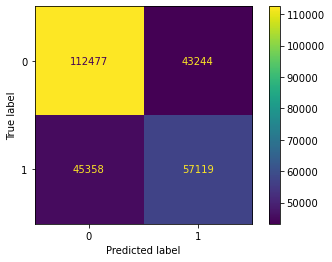

In [16]:
import matplotlib.pyplot as plt
like_preds = recsysxgb.infer(test_data, feature_columns_w_TE)[3].round()
print(sklearn.metrics.balanced_accuracy_score(test_data["has_like"]*1, like_preds))
print(sklearn.metrics.precision_score(test_data["has_like"]*1 , like_preds))
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(test_data["has_like"]*1, like_preds)).plot()
plt.show()

In [17]:
from utils.dataloader import RecSys2021PandasDataLoader
val_loader = RecSys2021PandasDataLoader(test_data, feature_columns_w_TE, mode = "validation")
res = recsysxgb.evaluate_validation_set(val_loader)
res

((0.07838889395626775,
  0.21017256831466424,
  0.01311680208030953,
  0.5497049910700084),
 (-10.895447388277212,
  -7.667416115453207,
  -35.1241308278595,
  -14.72609793741293))

In [22]:
res

((-11.980558944316488,
  0.2151621868957992,
  0.014035841385669563,
  0.5509188674378727),
 (-11.980558944316488,
  -7.355539671873346,
  -37.56595235666913,
  -12.942204554657044))

In [22]:
recsysxgb.clfs_["has_reply"].get_score(importance_type="gain")

{'TE_tweet_hash_has_reply': 62.22787582221791,
 'TE_b_hash_has_reply': 28.455619993834684,
 'TE_a_hash_has_reply': 20.471449685112496,
 'type_encoding': 5.046187223706666,
 'b_following': 0.6543604263666667,
 'TE_tweet_hash_has_retweet_comment': 5.34679594421154,
 'TE_tweet_hash_has_like': 1.2482774285117646,
 'TE_b_hash_has_like': 3.2116974821214272,
 'TE_b_hash_has_retweet_comment': 15.321340592249996,
 'a_followers': 2.262771235222105,
 'a_creation_delta': 0.9374418887999999,
 'hour_of_day': 0.5637817881111111,
 'bert_token_len': 0.6652109679361848,
 'b_followers': 0.7834144117333334,
 'a_following': 0.6242849637008333,
 'b_creation_delta': 0.9075859542571428,
 'a_is_verified': 0.28109640875833336,
 'a_follows_b': 5.1664734322250006,
 'TE_tweet_hash_has_retweet': 6.1951241224,
 'TE_a_hash_has_retweet_comment': 5.191675475502353,
 'language_encoding': 0.5869294612,
 'TE_a_hash_has_like': 2.2203893068615383,
 'TE_language_encoding_has_reply': 1.7514976512,
 'TE_b_hash_has_retweet': 4.

In [3]:
pd.read_csv("simple_pandas_run\\results.csv",  header=None)

,0,1,2,3,4,5
0,86E96F830895E40DAB8F24F86D83B86E,74D5CE3C365903C64566F9FA5BEECB9C,0.019257,0.115212,0.022055,0.326475
1,AEE204C567095381322449234EE86E81,9E2A5163444B160FCE11466F2FBA8916,0.038524,0.034698,0.017495,0.621212
2,9CA1C34EC7E003A5024D84CDED5F9F2A,BA119634422E2546D7DBABB6A5982EEF,0.116512,0.092753,0.038210,0.492120
3,369D6820D2C39E2E6028EC871E8AF2D7,2B8C960A90BEDC328D682E0E70226793,0.036331,0.045587,0.014722,0.673827
4,3A4270400ADBF900DD170EFE73CE7622,72C2F73E3F9E85735BC12772E7F1E00C,0.020974,0.114041,0.018272,0.232942
...,...,...,...,...,...,...
6021783,CD19AB894ABA72AD6C4B9D4BD82E4026,8522351239353E85F111767F8B25C34A,0.075917,0.041989,0.016296,0.348669
6021784,C4D0567E0D7BAA9206A8FE785BB91FB7,2CFA280F4AD55CEE5E782633977E5AF4,0.034605,0.133356,0.027635,0.498689
6021785,8E41EA985DB24BF917DC2F08E84D6889,43092FC9E166FD48ECD6609F45CD442B,0.048031,0.063350,0.018975,0.481854
6021786,F1D9CB611711282AD81EDB54727C177F,74D9CFFF7F2298849DA86C8A6F2BAB3F,0.032689,0.080162,0.023664,0.492081


In [5]:
#f2 = f2.drop(["reply","retweet","retweet_comment","like"], axis=1)
f2.head()

,bert_base_multilingual_cased_tokens,hashtags,tweet_id,medias,links,domains,type,language,timestamp,a_user_id,...,b_user_id,b_follower_count,b_following_count,b_is_verified,b_account_creation,a_follows_b,reply,retweet,retweet_comment,like
0,0,101\t56898\t137\t78722\t101518\t10113\t131\t14...,F057EABF27033C86635DACA39B75860A\tE4367F69BD34...,C23924CADFBB076A7D2D7F9096BF07B7,Photo,NaN,NaN,Retweet,9FCF19233EAD65EA6E32C2E6DC03A444,1612516671,...,1379690719,2CF8B49FB083BC4EC687C601F64EA8AD,683,689,False,1265254445,True,NaN,NaN,NaN
1,1,101\t12845\t10285\t62330\t10107\t10911\t10121\...,NaN,CB4EC1A0ECB0CCBCAD05420E96ED4DD8,NaN,NaN,NaN,Quote,B0FA488F2911701DD8EC5B1EA5E322D8,1613837103,...,1423845537,77AF0FFF70745B62F02E2C590AAB0541,588,1670,False,1304362682,False,NaN,NaN,NaN
2,2,101\t146\t11337\t20780\t13028\t119\t102,NaN,7CA02AC9EA45304CAFB61066DDF523ED,NaN,NaN,NaN,Quote,488B32D24BD4BB44172EB981C1BCA6FA,1613855527,...,1304754718,6E3596FBE5441CCAC38229755C8506F4,297,595,False,1528559689,True,NaN,NaN,NaN
3,3,101\t56898\t137\t105192\t105353\t21127\t10240\...,NaN,C324FDFA8D361DDA8C275B52F08311A7,Video,NaN,NaN,Retweet,9FCF19233EAD65EA6E32C2E6DC03A444,1612681684,...,1471693022,6F9E0D6DDCF0DD79E740C4A7F999EEC7,134,917,False,1531225320,False,NaN,NaN,NaN
4,4,101\t56898\t137\t11859\t11418\t85004\t10165\t1...,AB7684EA0831CFD4A6269EFC770A8397\t10420B9DA1F0...,25B61B9D047F7FA940AF0CC585F2EDF8,NaN,NaN,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,1612867625,...,1256282122,4B4E3B3AF68B830214A6BC2C25EAA708,224,184,False,1466501106,False,NaN,NaN,NaN


In [10]:
import pandas as pd
train = pd.read_parquet("preprocessed_training_features\\part.9.parquet")
test = pd.read_parquet("preprocessed_validation_features\\part.9.parquet")
train

,tweet_id,a_is_verified,b_user_id,b_is_verified,a_follows_b,has_reply,bert_token_len,has_retweet,has_retweet_comment,has_like,...,TE_a_hash_has_retweet_comment,TE_a_hash_has_retweet,TE_b_hash_has_reply,TE_b_hash_has_like,TE_b_hash_has_retweet_comment,TE_b_hash_has_retweet,TE_tweet_hash_has_reply,TE_tweet_hash_has_like,TE_tweet_hash_has_retweet_comment,TE_tweet_hash_has_retweet
idx,,,,,,,,,,,,,,,,,,,,,
2328504,FC917234BCAEEC9D838802CC92DF440E,False,AE40A3588E57FAD49B7A92A5EE576015,False,True,False,4.204693,False,False,False,...,0.006630,0.082996,0.027258,0.377806,0.006630,0.082996,0.027258,0.377806,0.006630,0.082996
2328505,A073D4352E0A2FD304064180355607F2,False,FAFD00BBD3FAF6F194F11491E9640919,False,True,False,3.091042,False,False,False,...,0.006630,0.082996,0.027258,0.377806,0.006630,0.082996,0.027258,0.377806,0.006630,0.082996
2328506,5D3B0DD135E64C788917F3E9474BDD72,False,C87EA3EF714D09A9ACB41CD4DFF05809,False,False,False,3.258097,False,False,True,...,0.006630,0.082996,0.026019,0.451542,0.006329,0.079223,0.027258,0.425425,0.006630,0.082996
2328507,8FEFB3031291D157ECBA60C68026C30E,False,D343CDD24E62335E6366C43DD08657FB,False,False,False,2.833213,False,False,True,...,0.002110,0.102165,0.027258,0.425425,0.006630,0.082996,0.027258,0.425425,0.006630,0.082996
2328508,5278984CBE0C3DB1C14FCEDA67713864,False,147868445045FEE47354296184358E12,False,False,False,3.496508,False,False,True,...,0.003570,0.070331,0.021200,0.441997,0.005157,0.101589,0.027258,0.425425,0.006630,0.082996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2587206,C8D2C3701D87551726382D08D18A22FE,False,169D946E742B2850A74178999E2877ED,False,True,False,4.204693,False,False,True,...,0.001379,0.106366,0.027258,0.425425,0.006630,0.082996,0.027258,0.425425,0.006630,0.082996
2587207,FF1CCC27DA37CF4857F2D5EF1C66C6EE,False,F3AAA2045AD502D941017AEC8BA23D04,False,False,False,3.637586,True,False,False,...,0.006054,0.119257,0.027258,0.377806,0.006630,0.130615,0.027258,0.377806,0.006630,0.130615
2587208,288DBA91E76CC73232310F1D6150C75F,True,CD37942BB577A87E9E6B0DC6A003410D,False,False,False,3.970292,False,False,True,...,0.024903,0.084103,0.018465,0.449481,0.004491,0.056223,0.023851,0.497247,0.005801,0.072621


0.5059247741028873

In [55]:
train[train["b_user_id"] == '7F6C55FBCE9A4FB981B1DF01807C121B']["b_hash"]

idx
2397455    6843327693395547848
Name: b_hash, dtype: int64

In [57]:
test[test["b_user_id"] == '7F6C55FBCE9A4FB981B1DF01807C121B']["b_hash"]

idx
2541356    7661512752241346398
Name: b_hash, dtype: int64

169374467480431641803362595042813022747

In [99]:
import numpy as np
np.array([int(str(int("7F6C55FBCE9A4FB981B1DF01807C121B", 16))[:20])], dtype=np.uint64)

array([16937446748043164180], dtype=uint64)

In [74]:
import ast
ast.literal_eval('0x7F6C55FBCE9A4FB981B1DF01807C121B')

169374467480431641803362595042813022747

In [9]:
int("7F6C55FBCE9A4FB981B1DF01807C121B", 16)%(2**32)

2155614747

In [16]:
train.columns

Index(['tweet_id', 'a_is_verified', 'b_user_id', 'b_is_verified',
       'a_follows_b', 'has_reply', 'bert_token_len', 'has_retweet',
       'has_retweet_comment', 'has_like', 'n_photos', 'n_videos', 'n_gifs',
       'type_encoding', 'language_encoding', 'a_followers', 'a_following',
       'b_followers', 'b_following', 'day_of_week', 'hour_of_day',
       'b_creation_delta', 'a_creation_delta', 'tweet_hash', 'b_hash',
       'a_hash', 'TE_language_encoding_has_reply',
       'TE_language_encoding_has_like',
       'TE_language_encoding_has_retweet_comment',
       'TE_language_encoding_has_retweet', 'TE_type_encoding_has_reply',
       'TE_type_encoding_has_like', 'TE_type_encoding_has_retweet_comment',
       'TE_type_encoding_has_retweet', 'TE_a_hash_has_reply',
       'TE_a_hash_has_like', 'TE_a_hash_has_retweet_comment',
       'TE_a_hash_has_retweet', 'TE_b_hash_has_reply', 'TE_b_hash_has_like',
       'TE_b_hash_has_retweet_comment', 'TE_b_hash_has_retweet',
       'TE_tweet_has

In [35]:
test_data.columns

Index(['tweet_id', 'a_is_verified', 'b_user_id', 'b_is_verified',
       'a_follows_b', 'has_reply', 'has_retweet', 'has_retweet_comment',
       'has_like', 'bert_token_len', 'n_photos', 'n_videos', 'n_gifs',
       'type_encoding', 'language_encoding', 'a_followers', 'a_following',
       'b_followers', 'b_following', 'day_of_week', 'hour_of_day',
       'b_creation_delta', 'a_creation_delta', 'tweet_hash', 'b_hash',
       'a_hash', 'TE_language_encoding_has_reply',
       'TE_language_encoding_has_like',
       'TE_language_encoding_has_retweet_comment',
       'TE_language_encoding_has_retweet', 'TE_type_encoding_has_reply',
       'TE_type_encoding_has_like', 'TE_type_encoding_has_retweet_comment',
       'TE_type_encoding_has_retweet', 'TE_a_hash_has_reply',
       'TE_a_hash_has_like', 'TE_a_hash_has_retweet_comment',
       'TE_a_hash_has_retweet', 'TE_b_hash_has_reply', 'TE_b_hash_has_like',
       'TE_b_hash_has_retweet_comment', 'TE_b_hash_has_retweet',
       'TE_tweet_has

In [69]:
test_data

,tweet_id,a_is_verified,b_user_id,b_is_verified,a_follows_b,has_reply,has_retweet,has_retweet_comment,has_like,bert_token_len,...,TE_a_hash_has_retweet_comment,TE_a_hash_has_retweet,TE_b_hash_has_reply,TE_b_hash_has_like,TE_b_hash_has_retweet_comment,TE_b_hash_has_retweet,TE_tweet_hash_has_reply,TE_tweet_hash_has_like,TE_tweet_hash_has_retweet_comment,TE_tweet_hash_has_retweet
idx,,,,,,,,,,,,,,,,,,,,,
257991,90CA38A0A5D53E50B3A53CB4799EDAC7,False,C6639036885D0E58206BE888CF8079E1,False,True,True,False,False,False,2.639057,...,0.006630,0.082996,0.022897,0.477357,0.005569,0.069717,-1.000000,-1.000000,-1.000000,-1.000000
257992,667A7A79B046C2630097E5F5575FF065,False,7CF0F5E830D6E29CA9A3E20398FBA987,False,True,False,False,False,False,3.737670,...,-1.000000,-1.000000,0.026019,0.406088,0.006329,0.079223,-1.000000,-1.000000,-1.000000,-1.000000
257993,9F3B4A2391BDE98F98DE6A62DC16ADB5,False,A78E7CE520EC824409084718FDE6C5B1,False,True,False,False,False,True,3.526361,...,0.049532,0.119257,0.019738,0.549446,0.004801,0.094583,-1.000000,-1.000000,-1.000000,-1.000000
257994,120991A57590B5D29D4E0A2733467E3C,True,4A3EF99CB4FEC651AAEC433CF7CA9912,False,False,False,False,False,False,3.713572,...,0.003238,0.040533,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
257995,95DD930F2F481228ACA4EE55730DA28F,False,50CD246006E987B5142F8BC3017354C6,False,False,False,False,False,False,4.595120,...,0.006329,0.079223,0.024888,0.431910,0.006054,0.119257,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516184,C634A10DD9BD635DC1893E50D9B114BE,False,970C80229B14B6B9C0FC4BE5F7721D71,False,True,False,False,False,True,2.944439,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
516185,B91D1773740A5FB8A77A7282225EEB01,True,4D1AD98E0CDC2C322A16AA97DA22C360,False,False,True,False,False,False,2.944439,...,0.005569,0.069717,0.026019,0.406088,0.006329,0.079223,-1.000000,-1.000000,-1.000000,-1.000000
516186,485093203DC4E4025B4725C42C6202DF,False,F527AAE1AB3CF95733380E05451E56FA,False,True,False,False,False,True,4.682131,...,0.006054,0.075779,0.027258,0.425425,0.006630,0.082996,-1.000000,-1.000000,-1.000000,-1.000000
